In [1]:
import torch
import math
from torch import nn
from d2l import torch as d2l
#掩蔽softmax操作
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作
    任何超出有效长度的位置都被掩蔽并置为0。
    X----输入张量
    valid_lens---有效长度
    """
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape=X.shape
        if valid_lens.dim()==1:
            valid_lens=torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens=valid_lens.reshape(-1)
         # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X=d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=1e6 )
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [2]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.0000, 0.0000, 0.5000, 0.5000],
         [0.0000, 0.0000, 0.5000, 0.5000]],

        [[0.0000, 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 1.0000]]])

使用二维张量，为矩阵样本中的每一行指定有效长度。

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[0.0000, 0.3333, 0.3333, 0.3333],
         [0.0000, 0.0000, 0.0000, 1.0000]],

        [[0.0000, 0.0000, 0.5000, 0.5000],
         [0.2639, 0.1778, 0.3269, 0.2314]]])

In [9]:
class AddictiveAttention(nn.Module):
    """加性注意力"""

    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AddictiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, quries, keys, values, valid_lens):
        quries, keys = self.W_q(quries), self.W_k(keys)
        #在维度扩展后，
        #queries的形状，(batch_size, 查询的个数，num_hidden)
        #key的形状：（batch_size, "键值对"的个数， num_hiddens)
        #使用广播方式进行求解
        features = quries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        #self.w_v仅有一个输出，我从此形状中移除最后那个维度
        #scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

查询、键和值的形状（批量大小、步数或词元序列长度，特征大小），实际输出(2, 1, 20)和(2, 10, 4)。注意力汇聚输出的形状为(批量大小、查询的步数，值的维度)。

In [10]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AddictiveAttention(key_size=2, query_size=20, num_hiddens=8,  dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[22., 23., 24., 25.]],

        [[30., 31., 32., 33.]]], grad_fn=<BmmBackward0>)

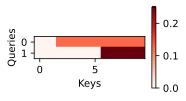

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')